# Build a L-layer Neural Network.ipynb

## Table of Contents

* [Recap](#chapter0)
* [1. L-laers Neural Network Model](#chapter1)
    * [1.1 Functions of our L-layers Neural Network ](#section_1_1)
        * [1.1.1 Initialize parameters](#section_1_1_1)
        * [1.1.2 Forward propagation](#section_1_1_2)
        * [1.1.3 Cost function](#section_1_1_3)
        * [1.1.4 Backward Propagation](#section_1_1_4)
        * [1.1.5 Update parameters](#section_1_1_5) 
    * [1.2 L-layer Model](#section_1_2)
* [2. Load the Dataset ](#chapter2)
    * [2.1 Load the Dataset](#section_2_1)
    * [2.2 Display the Data](#section_2_2)
    * [2.3 Flatten the data](#section_2_3)
    * [2.4 Normalize the data](#section_2_4)

# Recap  <a class="anchor" id="chapter0"></a>

> Forward Propagation :

<center><img src="images/05-Deep Neural network/forward-prop.png" width = "600px"></center>

$$
\begin{cases}
    Z^{[l]} = W^{[l]} X + b^{[l]} \\
    A^{[l]} = g^{[l]}(Z^{[l]}) 
\end{cases}
$$


> Backward Propagation :

<center><img src="images/05-Deep Neural network/backward-prop.png" width = "600px"></center>

$$
\begin{cases}
    dZ^{[l]} =  dA^{[l]}  * g^{[l]'}(Z^{[l]}) \\
    dW^{[l]} = \frac{1}{m} dZ^{[l]}A^{[l-1]T} \\
    db^{[l]} = \frac{1}{m} \sum dZ^{[l]}    \\
    dA^{[l-1]} =W^{[l]T}dZ^{[l]} \\
    dZ^{[l-1]} = W^{[l]T}dZ^{[l]} * g^{[l-1]'}(Z^{[l-1]}) \\
\end{cases}
$$

$$
\begin{cases}
    dZ^{[1]} = W^{[2]T}dZ^{[2]} * g^{[1]'}(Z^{[1]}) \\
    dW^{[1]} = \frac{1}{m} dZ^{[1]} X^T \\
    db^{[1]} = \frac{1}{m} \sum  dZ^{[1]}
\end{cases}
$$


> Dimension :
- m : number of examples

$$\begin{cases}
    Z^{[l]},A^{[l]} : (n^{[l]},m) \\
    W^{[l]}: (n^{[l]},n^{[l-1]})   \\
    b^{[l]}: (n^{[l]},1)  \\
    dZ^{[l]},dA^{[l]} : (n^{[l]},m) \\
    dW^{[l]} : (n^{[l]},n^{[l-1]})   \\
    db^{[l]}: (n^{[l]},1)
\end{cases}
$$


# 1. L-layers Neural Network model <a class="anchor" id="chapter1"></a>

In [3]:
# Packages
import copy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


%matplotlib inline

## 1.1 Functions of our L-layers Neural Network  <a class="anchor" id="section_1_1"></a>

### 1.1.1 Initialize parameters  <a class="anchor" id="section_1_1_1"></a>

In [241]:
def initialize_parameters(hidden_layers_dim,n_input,n_output):
    """
    Initialize the l parameters of the L-layer neural network
    
    Arguments:
    hidden_layers_dim -- list of hidden units in the hidden layers
    n_input -- features of the input matrix X
    n_output -- number units in the output layer 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2, ....
    """

    # seed
    np.random.seed(3)

    # init cache
    parameters = {}
    l = len(hidden_layers_dim)

    for i,n_dim in enumerate(hidden_layers_dim):
        
        if i == 0:
            W = np.random.randn(n_dim,n_input) * 0.01
            b = np.zeros((n_dim,1))
        else:
            W = np.random.randn(n_dim,hidden_layers_dim[i-1]) * 0.01
            b = np.zeros((n_dim,1))

        # getting params
        parameters[f"W{i+1}"] = W
        parameters[f"b{i+1}" ] = b

    # output layer
    W = np.random.randn(n_output,hidden_layers_dim[-1]) * 0.01
    b = np.zeros((n_output,1))
    

    # getting params
    parameters[f"W{l+1}"] = W
    parameters[f"b{l+1}" ] = b


    return parameters


In [242]:
# test
layers_dim = [5,5,3]

params = initialize_parameters(layers_dim,4,1)
params

{'W1': array([[ 0.01788628,  0.0043651 ,  0.00096497, -0.01863493],
        [-0.00277388, -0.00354759, -0.00082741, -0.00627001],
        [-0.00043818, -0.00477218, -0.01313865,  0.00884622],
        [ 0.00881318,  0.01709573,  0.00050034, -0.00404677],
        [-0.0054536 , -0.01546477,  0.00982367, -0.01101068]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 'W2': array([[-0.01185047, -0.0020565 ,  0.01486148,  0.00236716, -0.01023785],
        [-0.00712993,  0.00625245, -0.00160513, -0.00768836, -0.00230031],
        [ 0.00745056,  0.01976111, -0.01244123, -0.00626417, -0.00803766],
        [-0.02419083, -0.00923792, -0.01023876,  0.01123978, -0.00131914],
        [-0.01623285,  0.00646675, -0.00356271, -0.01743141, -0.0059665 ]]),
 'b2': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 'W3': array([[-0.00588594, -0.00873882,  0.00029714, -0.02248258, -0.00267762],
        [ 0.01013183,  0.00852798,  0.01108187,  0.01119391,  

### 1.1.2 Forward propagation  <a class="anchor" id="section_1_1_2"></a>

In [243]:
def activation_function(Z,activation_name):

    """
    Compute the activation function
    
    Arguments:
    activation_name -- name of the activation function choosen
    Z -- items

    Returns:
    activation -- activation value
    """

    if activation_name.lower() == "sigmoid":

        activation = 1 / (1+np.exp(-Z))

    elif activation_name.lower() == "relu":

        activation = np.maximum(0,Z)

    elif activation_name.lower() == "tanh":

        activation = np.tanh(Z)
    else:
        # default activation function
        activation = np.maximum(0,Z)


    assert(activation.shape == Z.shape)

    return activation

In [244]:
# test activation
Z = np.random.randn(10,100)
A = activation_function(Z,"sigmoid")

print(A.shape)

(10, 100)


In [245]:
def Forward_propagation(X,parameters):

    """
    Compute the forward propagation on the L layers
    
    Arguments:
    X -- Input
    parameters -- dictionnary containing the parameters of each layers

    Returns:
    caches -- list of dictionnaries. each dictionnay contains the linear result and activation of each layer
    """

    # caches and layers
    caches = []
    L = len(parameters)//2
    
    # Input X
    A_prev = X

    for i in range(L):

        # getting the parameters of the i-th layers
        W = parameters[f"W{i+1}"]
        b = parameters[f"b{i+1}"]

        # linear and activation result
        Z = np.dot(W,A_prev) + b

        # activation
        if i == L - 1 :
            A = activation_function(Z,"sigmoid")
        else:
            A = activation_function(Z,"relu")

        # append cache
        cache = {"W":W,"b":b,"Z":Z,"A":A,"A_prev":A_prev}
        caches.append(cache)

        # change A_prev
        A_prev = A

    return A, caches

In [246]:
# test
layers_dim = [5,5,3]
X = np.random.randn(2,100)
params = initialize_parameters(layers_dim,X.shape[0],1)

AL,caches = Forward_propagation(X,params)

for val in caches:
    print(val["W"].shape)

(5, 2)
(5, 5)
(3, 5)
(1, 3)


### 1.1.3 Cost function  <a class="anchor" id="section_1_1_3"></a>

In [247]:
def cost_function(AL,y):

    """
    Compute the cost after the forward propagation

    Arguments:
    AL -- L-activation 
    y -- true labels of the dataset dim = (n_y,m) | m examples, n_y nodes of the output layer

    Returns:
    cost -- cost value
    """
    # m  examples
    m = y.shape[1]

    # cost
    cost = -(1/m) *(np.dot(y,np.log(AL).T) + np.dot((1-y),np.log(1-AL).T))
    cost = np.squeeze(cost)

    return cost


In [248]:
# Test the cost
y_true = np.random.randint(0,2,(1,100))
y_pred = np.random.random((1,100))

# check with the true log_loss
cost = cost_function(y_pred,y_true)
l_cost = log_loss(y_true.T,y_pred.T)
print(cost)
print(l_cost)

1.0045892596933899
1.0045892596933899


### 1.1.4 Backward Propagation  <a class="anchor" id="section_1_1_4"></a>

In [249]:
def backward_activation_function(dA,Z, function_name):

    if function_name.lower() == "sigmoid":

        Z = Z
        s = 1/(1+np.exp(-Z))
        
        dZ = dA * s * (1-s)

    elif function_name.lower() == "relu":

        Z = Z
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.
       
        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

    elif function_name.lower() == "tanh":
        Z = Z
        s = np.tanh(Z)

        dZ = dA * (1-np.power(s,2))
    
    else:
        #default: relu
        Z = Z
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

    
    return dZ



In [250]:
def backward_propagation(AL,y,caches):
    
    # gradients
    gradients = {}

    # L layers
    L = len(caches)

    # m examples
    m = y.shape[1]

    # dAL 
    dAL = - (np.divide(y, AL) - np.divide(1 - y, 1 - AL))
    
    # getting caches variables
    current_cache = caches[-1]
    WL = current_cache["W"]
    ZL = current_cache["Z"]
    A_prev = current_cache["A_prev"]
    
    dZ = backward_activation_function(dAL,ZL,"sigmoid")
    
    dW_temp = (1/m) * np.dot(dZ,A_prev.T)
    db_temp = (1/m) * np.sum(dZ,axis=1, keepdims=True)
    dA_prev_temp = np.dot(WL.T,dZ)
    
    # compute the gradient
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp
    

    for i in reversed(range(L-1)):
        # getting caches variables
        current_cache = caches[i]
       
        W = current_cache["W"]
        Z = current_cache["Z"]
        A_prev = current_cache["A_prev"]

        dZ = backward_activation_function(dA_prev_temp,Z,"relu")
       
        dW_temp = (1/m) * np.dot(dZ,A_prev.T)
        db_temp = (1/m) * np.sum(dZ,axis=1, keepdims=True)
        dA_prev_temp = np.dot(W.T,dZ)
        
        # compute the gradient
        gradients["dW" + str(i+1)] = dW_temp
        gradients["db" + str(i+1)] = db_temp


    return gradients

In [251]:
# test

layers_dim = [5,5,4]
X = np.random.randn(10,100)
y_true = np.random.randint(0,2,(1,100))
params = initialize_parameters(layers_dim,X.shape[0],1)

AL,caches = Forward_propagation(X,params)
    
gradients = backward_propagation(AL,y_true,caches)

for i in range(len(caches)):
    print(f"dW{i+1}",gradients[f"dW{i+1}"].shape)

dW1 (5, 10)
dW2 (5, 5)
dW3 (4, 5)
dW4 (1, 4)


### 1.1.5 Update parameters  <a class="anchor" id="section_1_1_5"></a>

In [260]:
def update_parameters(parameters,gradients,learning_rate):

    params = parameters.copy()
    L = len(parameters)//2


    for i in range(L):

        params[f"W{i+1}"] = params[f"W{i+1}"] - learning_rate * gradients[f"dW{i+1}"]
        params[f"b{i+1}"] = params[f"b{i+1}"] - learning_rate * gradients[f"db{i+1}"]

    return params

### 1.1.6 Predict <a class="anchor" id="section_1_1_6"></a>

In [253]:
def predict(X,y,parameters):

    y_pred,caches = Forward_propagation(X,parameters)

    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0

    return y_pred

## 1.2 L-layer Model <a class="anchor" id="section_1_2"></a>

In [275]:
def L_nn_model(X,y,n_iter,hidden_layers_dim,learning_rate, display = False):

    n_x = X.shape[0]
    n_y = y.shape[0]

    # tracking
    costs = [] 
    acc = []

    # initialize parameters
    parameters = initialize_parameters(hidden_layers_dim, n_x, n_y)

    for iteration in range(n_iter):

        # ---- forward  propagation -----------
        AL,caches = Forward_propagation(X,parameters)

        # --------- cost -----------------
        cost_train = cost_function(AL,y)
        costs.append(cost_train)
       
        y_pred = predict(X,y,parameters)
        acc_train = accuracy_score(y.T,y_pred.T)
        acc.append(acc_train)

        # ---- backward propagation --------------
        gradients = backward_propagation(AL,y,caches)

        # ---- update parameters ----------
        parameters = update_parameters(parameters, gradients, learning_rate)


        if display is True and iteration%250 == 0:
            print(f"iter {iteration} : Train_Loss = {cost_train}, Train_acc = {acc_train}")


    dict_model = {"parameters": parameters,"cost":costs,"accuracy":acc}

    return dict_model
    

# 2. Load the Dataset <a class="anchor" id="chapter2"></a>

## 2.1 Load the data <a class="anchor" id="section_2_1"></a>

In [229]:
# Load the dataset
import h5py
dataset_file = "datasets/01 - cat/"

def load_dataset():

    # Training set
    train_dataset = h5py.File(dataset_file + "train_catvnoncat.h5","r")
    X_train = np.array(train_dataset["train_set_x"][:])
    y_train = np.array(train_dataset["train_set_y"][:])

    # Test set
    test_dataset = h5py.File(dataset_file + "test_catvnoncat.h5","r")
    X_test = np.array(test_dataset["test_set_x"][:])
    y_test = np.array(test_dataset["test_set_y"][:])

    # classes
    classes = np.array(test_dataset["list_classes"][:])

    return X_train, y_train, X_test, y_test, classes

In [231]:
# split
train_x,train_y, test_x, test_y,classes = load_dataset()

In [232]:
# Display Shape
print("X_train shape:", train_x.shape)
print("X_test shape:", test_x.shape)
print("y_train shape:", train_y.shape)
print("y_test shape:",test_y.shape)
print("classes shape:",classes.shape)

X_train shape: (209, 64, 64, 3)
X_test shape: (50, 64, 64, 3)
y_train shape: (209,)
y_test shape: (50,)
classes shape: (2,)


In [233]:
# We need to reshape y_train and y_test

train_y = train_y.reshape((1,train_y.shape[0]))
test_y = test_y.reshape((1,test_y.shape[0]))

print("y_train shape:", train_y.shape)
print("y_test shape:",test_y.shape)

y_train shape: (1, 209)
y_test shape: (1, 50)


## 2.2 Display <a class="anchor" id="section_2_2"></a>

In [235]:
def display_data(X,y,n,classes = {0: "cat",1:"dog"}):
    """
    Display n random image in the dataset X,y

    ----
    Inputs:
    - X : Matrix containing the features and the examples
    - y : True label of the dataset X
    - n : number of images plot
    """
    # Random range
    random_range = np.random.randint(0,X.shape[0],size=n)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    
    for i in range(n):
        index = random_range[i]
        index_classe = int(np.squeeze(y[index]))

        ax = axs[i]
        ax.imshow(X[index],cmap="gray")
        ax.set_title(f"y={index_classe} | {classes[index_classe]}".capitalize())

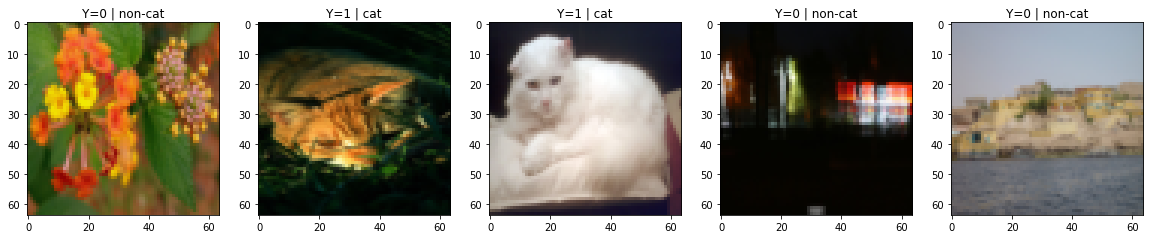

In [236]:
display_data(train_x,train_y.T,5,classes = {0: "non-cat",1:"cat"})

## 2.3 Flatten <a class="anchor" id="section_2_3"></a>

In [237]:
# Flatten

train_x_flat = train_x.reshape(train_x.shape[0],-1).T
test_x_flat = test_x.reshape(test_x.shape[0],-1).T


print("X_train flatten shape:",train_x_flat.shape)
print("X_test flatten shape:",test_x_flat.shape)

X_train flatten shape: (12288, 209)
X_test flatten shape: (12288, 50)


## 2.4 Normalize <a class="anchor" id="section_2_4"></a>

In [279]:
# Normalize

train_x_flat_norm = train_x_flat/np.max(train_x_flat)

# Warning: the data are normalized with the Training set
test_x_flat_norm = test_x_flat/np.max(train_x_flat)

# 3. Train the model  <a class="anchor" id="chapter3"></a>

In [276]:
n_iter= 2500
hidden_layers_dim = [20,7,5]
learning_rate = 0.0075
dict_model = L_nn_model(train_x_flat_norm,train_y,n_iter,hidden_layers_dim,learning_rate,display=True)

iter 0 : Train_Loss = 0.6931477726957999, Train_acc = 0.3444976076555024 (1, 209) (1, 209)
iter 250 : Train_Loss = 0.6636794901684017, Train_acc = 0.6555023923444976 (1, 209) (1, 209)
iter 500 : Train_Loss = 0.6520134603618387, Train_acc = 0.6555023923444976 (1, 209) (1, 209)
iter 750 : Train_Loss = 0.6473037941387403, Train_acc = 0.6555023923444976 (1, 209) (1, 209)
iter 1000 : Train_Loss = 0.6453683565180596, Train_acc = 0.6555023923444976 (1, 209) (1, 209)


KeyboardInterrupt: 

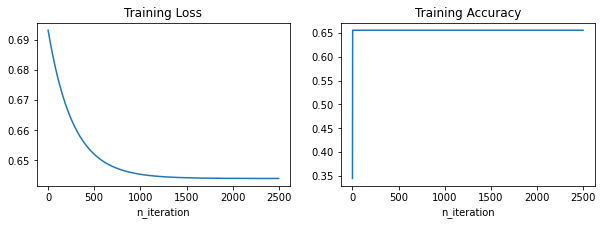

In [274]:
# Display the result

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(dict_model["cost"])
axs[0].set_title("Training Loss")
axs[0].set_xlabel("n_iteration")

axs[1].plot(dict_model["accuracy"])
axs[1].set_title("Training Accuracy")
axs[1].set_xlabel("n_iteration")
plt.show()